# **Expectation-Maximization algorithm** (hidden model)
### Author: Martí Cortada Garcia
---

In [1]:
# Import required libraries
import numpy as np
from Bio import SeqIO, Phylo
from io import StringIO
from collections import Counter, OrderedDict
import itertools

### **Input:**
We have a tree $T$ (where the root corresponds to the internal node codified as `Int_0`) and the alignments of the leaves.

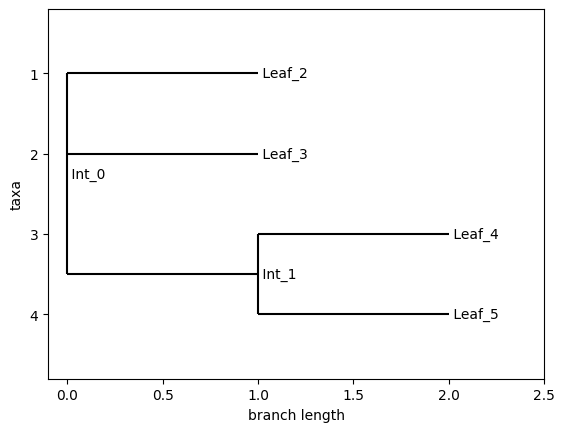

In [2]:
newick_tree = "(2,3,(4,5))"
tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [3]:
leave_alignments = [i for i in SeqIO.parse("4_leaves_1000length_sequences.fasta", "fasta")]
for i in leave_alignments:
    print("Seq>", i.seq)

Seq> CTCAAGCCTCCGAGCGACAAGCTTCAACTAATCGGTCTGAGAACCCAATATATAATGTTGAACGAACCGATCAAATCTCCATCCTAACGGAACAATGATTTTGTCGCAGATTAAACATCAAAGGGGCGTAGGCAGTACTTGAGACAACCCCTCCCGTCGGTGCAACGTTAAGCAGCGTGCTGTGACCGACATTTACACTTACCTACAGCTTCACGATCGTGAATGTGGTCCGGTGGTTCAGGTCAGCGTCATTATGGGTCCCCACTCCCATCTTAATAACTCTGCCAGATATCCTGAACTTATAAGGAAAGATGATACTCGTATGGTCCGTTATTGTCACAATAGGCAGCAATTCACGCAATTGTTGTAGCACCCTTAAGAGGGAATAGGGAGAATGATCCCCTGAATGAGCTCAGTCTGTGTACGCCAGTTCCGTAGTGGAGTCTTACGCCAATGACAGGGACAACGCCCCATGATAGCCCCGGTCAACAAGCCTGGTTATTGGCTTATTGCATTCGTCCGCCAACCCCTAACGCCCGTTTGGTGGCTACACGGATAAATGATCAACAACCTAATGGGATCGTAAACCTGAGCGAGCTCCGGCGTCATCGGTCTCTTACTAACATATCACGTACTCCGTGCCTGGGAACCTAGGGGCTTTTTCTTATAGGTGATGCTGCCCCCCACTGAAAGAGCGTCACATATCACACTCATTTTTCTATTCGAGGGCATACAATATGTATGTGATCCCGCTATACAGTGTAAATGCGTCAAGTCAAGCGAGCGCATATCTCAGAGCATATAGTTAGGCCCTGGCTTTCTGTCCGTCTTAACTACCATAACTCCGTATTATTGTCCATAGTGAAAGGGCATGAGTCGATCGACCACGATAGAGCAACGTTTTGAAGATATTGAAGATCCTTTAGCGTCACAGCTGCGGTCTTCTTCCTACCCGTTATTCAAGTCGAATGTTCCGTCATGTCTCTCGCAGTTTT

Moreover, we codify the alphabet $\sum=\{A,G,C,T\}\to\{0,1,2,3\}$

In [4]:
leave_sequences = []
for i in leave_alignments:
    seq = ""
    for j in i.seq:
        if j == "A":
            seq += "0"
        elif j == "G":
            seq += "1"
        elif j == "C":
            seq += "2"
        elif j == "T":
            seq += "3"
        else:
            raise ValueError("Invalid nucleotide")
    leave_sequences.append(seq)

leave_sequences

['23200122322101210200123320023003211323101002220030303003133100210022103200032322032230021100200310333313212010330002032000111121301120130233101020022223222132113120021330012012131231310221020333020233022302012332021032131003131132211311332011320121320330311132222023222032330030023231220103032231002330300110001031030232130311322133033132020030112012003320212003313313012022233001011100301110100310322223100310123201323131302122013322130131101323302122003102011102002122220310301222211320020012231133033112330331203321322122002222300212221333113112302021103000310320020022300311103213000223101210123221121320321132323302300203032021302322131223111002230111123333323303011310312312222220231000101213202030320202320333332303321011120302003031303131032221230302013130003121320013200121012120303232010120303013301122231123332313221323300230220300232213033033132203013100011120310132103210220210301012002133331001030331001032233301213202012312113233233223022213303320013210031332213203132323212013333222

where the previous sequencies have been generated with the following parameters:

In [5]:
M_root_to_leaf2 = np.array([[0.67781054, 0.07466279, 0.1205998, 0.12692686], [0.08371281, 0.71004812, 0.08640399, 0.11983508], [0.0957915, 0.1044398,  0.71133383, 0.08843488], [0.11570591, 0.09873057, 0.0840438, 0.70151972]])
M_root_to_leaf3 = np.array([[0.68092156, 0.08546336, 0.10472156, 0.12889352], [0.08863481, 0.6951298 , 0.08641648, 0.12981891], [0.09464835, 0.09638309, 0.71981502, 0.08915354], [0.0833322, 0.09754567, 0.10675413, 0.71236799]])
M_root_to_node1 = np.array([[0.6592648 , 0.07939543, 0.11402445, 0.14731532], [0.09043177, 0.7000641 , 0.1164545 , 0.09304964], [0.0839887 , 0.09532453, 0.69092513, 0.12976165], [0.09255666, 0.11016143, 0.08501808, 0.71226383]])
M_node1_to_leaf4 = np.array([[0.67145996, 0.10410964, 0.10247415, 0.12195626], [0.11561701, 0.68456579, 0.11335696, 0.08646025], [0.09854579, 0.09659594, 0.71662829, 0.08822998], [0.08112586, 0.08950085, 0.12349954, 0.70587375]])
M_node1_to_leaf5 = np.array([[0.65363449, 0.07652442, 0.10482714, 0.16501394], [0.08349303, 0.69217288, 0.11542616, 0.10890792], [0.10121279, 0.10635535, 0.70522391, 0.08720795], [0.0945611 , 0.08778159, 0.10371737, 0.71393994]])

root_distribution = np.array([0.25, 0.25, 0.25, 0.25])

### **Step 0**: 
Initialise parameters

In [6]:
eps = 10**(-3) # epsilon for convergence

# Initialise estimation for the root distribution (all probabilities between 0.2 and 0.3)
def init_root_distribution():
    estimated_root_distribution = []
    while True:
        estimated_root_distribution = np.random.dirichlet([1,1,1,1])
        i = 0
        while i<4:
            if estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3:
                i += 1
            else:
                break
        if i == 4:
            assert(np.sum(estimated_root_distribution) < 1.0000001 and np.sum(estimated_root_distribution) > 0.9999999)
            assert(estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3 for i in range(4))
            break

estimated_root_distribution = init_root_distribution()

# Initialise estimation for the transition matrices (which we estimate as LARGE-DIAGONAL-VALUE matrices)
def init_transition_matrix():
    M = np.zeros((4,4))
    i=0
    while i<4:
        R = np.random.dirichlet([1,1,1,1])
        if R[i] > 0.6 and R[i] < 0.8:
            M[i,:] = R 
            i = i + 1
    assert (M[i,i] > 0.6 and M[i,i] < 0.8 for i in range(4))
    assert (np.sum(M[i,:]) < 1.0000001 and np.sum(M[i,:]) > 0.9999999 for i in range(4))
    return M


Define a `class` that stores the information for the given tree:

In [7]:
class Tree:
    def __init__(self, edge, transition_matrix, alignment=None):
        self.edge = edge
        self.transition_matrix = transition_matrix
        self.alignment = alignment # it will only be placed in the leaves


In [8]:
params = []

for edge in net.edges():
    # If we are in a leaf, we need to specify the alignment
    iter_leaves = 0
    if edge[1].name.startswith("L"):
        new_edge = Tree(edge, init_transition_matrix(), leave_alignments[iter_leaves].seq)
        iter_leaves += 1
    # Otherwise, are in internal nodes
    else:
        new_edge = Tree(edge, init_transition_matrix())
    params.append(new_edge)

We check all the initialisation parameters:

In [9]:
for i in params:
    print("Edge:", i.edge)
    print("Transition matrix:\n", i.transition_matrix)
    print("Alignment:\n", i.alignment)
    print("---"*30)

Edge: (Clade(name='Int_0'), Clade(name='Leaf_2'))
Transition matrix:
 [[0.72793698 0.05159877 0.05470631 0.16575793]
 [0.10170942 0.78243433 0.08373216 0.0321241 ]
 [0.10535196 0.03975478 0.63159933 0.22329393]
 [0.21778162 0.01615469 0.16238193 0.60368176]]
Alignment:
 CTCAAGCCTCCGAGCGACAAGCTTCAACTAATCGGTCTGAGAACCCAATATATAATGTTGAACGAACCGATCAAATCTCCATCCTAACGGAACAATGATTTTGTCGCAGATTAAACATCAAAGGGGCGTAGGCAGTACTTGAGACAACCCCTCCCGTCGGTGCAACGTTAAGCAGCGTGCTGTGACCGACATTTACACTTACCTACAGCTTCACGATCGTGAATGTGGTCCGGTGGTTCAGGTCAGCGTCATTATGGGTCCCCACTCCCATCTTAATAACTCTGCCAGATATCCTGAACTTATAAGGAAAGATGATACTCGTATGGTCCGTTATTGTCACAATAGGCAGCAATTCACGCAATTGTTGTAGCACCCTTAAGAGGGAATAGGGAGAATGATCCCCTGAATGAGCTCAGTCTGTGTACGCCAGTTCCGTAGTGGAGTCTTACGCCAATGACAGGGACAACGCCCCATGATAGCCCCGGTCAACAAGCCTGGTTATTGGCTTATTGCATTCGTCCGCCAACCCCTAACGCCCGTTTGGTGGCTACACGGATAAATGATCAACAACCTAATGGGATCGTAAACCTGAGCGAGCTCCGGCGTCATCGGTCTCTTACTAACATATCACGTACTCCGTGCCTGGGAACCTAGGGGCTTTTTCTTATAGGTGATGCTGCCCCCCACTGAAAGAGCGTCACATATCACACTCATTTTTCTATTCGAGGG

### **E-step**:
Define the *expected hidden data matrix* $U$, where $u_{i,j}=u_i\frac{f_{i,j}(\theta)}{\sum_{j=1}^m f_{i,j}(\theta)}=\frac{u_i}{f_i(\theta)}f_{i,j}(\theta)$.

In [41]:
# Obtain number of leaves and internal nodes
n_leaves, n_int = 0, 0 
for node in net.nodes():
    if node.name.startswith("L"):
        n_leaves += 1
    else:
        n_int += 1

# Define the empty U matrix with dimensions (4^{n_leaves}, 4^{n_int})
U = np.zeros((4**n_leaves, 4**n_int))

# Count all the leaves ocurrences 
sequence_length = len(leave_sequences[0])
number_of_sequences = len(leave_sequences)
occurrences = []
for i in range(sequence_length):
    _ = ''
    for j in range(number_of_sequences):
        _ += leave_sequences[j][i]
    occurrences.append(_)

# All possible (theoretical) occurrences of nucleotides in the leaves
alphabet = [0, 1, 2, 3]
combinations = itertools.product(alphabet, repeat=number_of_sequences)
sorted_combinations = sorted(combinations)
for i in range(len(sorted_combinations)):
    sorted_combinations[i] = ''.join([str(s) for s in sorted_combinations[i]])

# Check how many times each occurrence of nucleotides appears (i.e. u_i) 
# Those occurrences that are not present in the given tree will have value equal to 0 
c = Counter(occurrences)
u_i = OrderedDict(sorted(c.items()))
for i in sorted_combinations:
    try:
        u_i[i] = u_i[i] # if it exists, keep going!
    except:
        u_i[i] = 0 # if it does not exist, we have 0 occurrences, we create a new entry
assert (len(u_i) == len(sorted_combinations))

